# Import Libaries

In [1]:
import glob
import cv2
import time

import numpy as np

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from skimage.feature import hog

from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.grid_search import GridSearchCV
from sklearn.utils import shuffle

from scipy.ndimage.measurements import label
%matplotlib inline

D:\ProgramFiles\Anaconda\envs\carnd-term1\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
D:\ProgramFiles\Anaconda\envs\carnd-term1\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


# Extract Features from Images

D:\ProgramFiles\Anaconda\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:248: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


(720, 1280, 3)


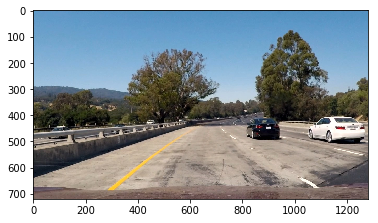

In [2]:
img_test = mpimg.imread("./test_images/test1.jpg")
img_test2 = mpimg.imread("./vehicles/GTI_FAR/image0000.png")
# function to get hog features
# for block_n parameter, 0->"L1", 1->"L1-sqrt", 2->"L2", 3->"L2-Hys"
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    # all default arguments
    return_list = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), \
                               cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, \
                               visualise = vis, feature_vector=feature_vec, block_norm='L2-Hys')
    
    if vis == True:
        hog_img = return_list[1]
        return return_list[0], hog_img
    else:
        return return_list

# function to compute binned color spaces
def bin_spatial(img, size):
    # using luminance color channel from yuv color spaces 
#     img_yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img_luma = img[:,:,0]
    color_features = cv2.resize(img_luma, (size,size)).ravel()
    return color_features

# function to compute color histogram features
def color_hist(img, nbins, bin_range=(0,256)):
    rhist = np.histogram(img[:,:,0], bins=nbins, range=bin_range)
    ghist = np.histogram(img[:,:,1], bins=nbins, range=bin_range)
    bhist = np.histogram(img[:,:,2], bins=nbins, range=bin_range)
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    return hist_features

# define a function to extract featrues from a single feature
def single_features(img, nbins, size, orient, pix_per_cell, cell_per_block):
    # create a list to append feature vectors to
    features = []
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img_forhog = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # histogram features
    hist_features = color_hist(img, nbins)
    # color space featuresorient, pix_per_cell, cell_per_block, block_n
    color_features = bin_spatial(img, size)
    # hog features of every channel in the image
    hog_features = []
    
    hog_features.append(get_hog_features(img_forhog, orient, pix_per_cell, cell_per_block, vis=False))
    hog_features = np.ravel(hog_features)
    features = np.hstack((hist_features, color_features, hog_features))
    
    return features

# funciton to extract features from an image
def extract_features(imgs, nbins, size, orient, pix_per_cell, cell_per_block):
    # create a list to append feature vectors to
    features = []
    # iterate through the list of images
    for file in imgs:
        file_features = []
        img = mpimg.imread(file)
        file_features = single_features(img, 32, 32, 9, 8, 2)
        features.append(file_features)
    
    return features

# test this block
img_copy = np.copy(img_test2)
gray = cv2.cvtColor(img_copy, cv2.COLOR_RGB2GRAY)
hog_features, hog_img = get_hog_features(img_copy[:,:,0], 9, 8, 2, vis=True)
imgs = ["test_images/test1.jpg"]
features = extract_features(imgs, 32, 32, 9, 8, 2)
# plt.subplot(2,1,1)
plt.imshow(img_test)
# plt.subplot(2,1,2)
# plt.imshow(hog_img, cmap='gray')
print(img_test.shape)

In [3]:
HOG_TRY=get_hog_features(img_test[:,:,0], 12, 8, 2, vis=False)
HOG_TRY

D:\ProgramFiles\Anaconda\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:248: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


array([ 0.31506356,  0.23448533,  0.31506356, ...,  0.08480846,
        0.        ,  0.05727464])

# Slide Windows Function

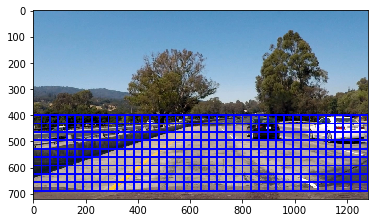

In [4]:
# sliding window function
def slide_window(img, xy_window, x_start_stop=[None, None], y_start_stop=[400, 700], xy_overlap=[0.5,0.5]):
    # compute start and end point of the region to apply sliding point
    if x_start_stop[0]==None:
        x_start_stop[0]=0
    if x_start_stop[1]==None:
        x_start_stop[1]=img.shape[1]
    if y_start_stop[0]==None:
        y_start_stop[0]=0
    if y_start_stop[1]==None:
        y_start_stop[1]=img.shape[0]
    # compute the span of the region to be searched
    xspan = x_start_stop[1]-x_start_stop[0]
    yspan = y_start_stop[1]-y_start_stop[0]
    # compute the number of pixels per step in x/y
    xstep = np.int(xy_window[0]*(1-xy_overlap[0]))
    ystep = np.int(xy_window[1]*(1-xy_overlap[1]))
    # compute the number of windows in x/y
    xbuff = xy_window[0]*xy_overlap[0]
    ybuff = xy_window[1]*xy_overlap[1]
    nx_windows = np.int((xspan-xbuff)/xstep)
    ny_windows = np.int((yspan-ybuff)/ystep)
    # initialize a list to append windows positons to
    windows = []
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            startx = xstep*xs+x_start_stop[0]
            endx = startx+xy_window[0]
            starty = ystep*ys+y_start_stop[0]
            endy = starty+xy_window[1]
            windows.append(((startx, starty),(endx, endy)))
    return windows

# function to draw boxes
def draw_boxes(img, bboxes, color=(0,0,255), thick=6):
    img_copy = np.copy(img)
    for box in bboxes:
        cv2.rectangle(img_copy, box[0], box[1], color, thick)
    return img_copy

# test this block
windows = slide_window(img_test, [64, 64])
img_slid = draw_boxes(img_test, windows)
plt.imshow(img_slid)

# Prepare Training&Testing Data

In [5]:
# prepare training and testing data

def ML_train(find):
    # prepare and output the training data
    # randomly shuffle the original data
    data_cars = glob.glob('./vehicles/*/*.png')
    data_notcars = glob.glob('./non-vehicles/Extras/*.png')
#     data_notcars_argu = glob.glob('./non-vehicles/GTI/*.png')
#     data_notcars_argu = shuffle(data_notcars_argu, n_samples=1000)
#     data_notcars.extend(data_notcars_argu)
    
    # set shuffle parameter to Ture to randomly shuffle the training data(although the default value of shuffle is True already...)
    data_cars_train, data_cars_test = train_test_split(data_cars, test_size=0.2, shuffle=True)
    data_notcars_train, data_notcars_test = train_test_split(data_notcars, test_size=0.2, shuffle=True)
    
    # data for training
    if find==True:
        train_data_cars_part = shuffle(data_cars_train, n_samples=500)
        train_data_notcars_part = shuffle(data_notcars_train, n_samples=500)
    else:
        train_data_cars_part = data_cars_train
        train_data_notcars_part = data_notcars_train
    
    car_features = extract_features(train_data_cars_part, 32, 32, 9, 8, 2)
    notcar_features = extract_features(train_data_notcars_part, 32, 32, 9, 8, 2)
    X_train = np.vstack((car_features,notcar_features)).astype(np.float64)
    y_train = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
    # normalize the data
    X_scaler = StandardScaler().fit(X_train)
    X_train = X_scaler.transform(X_train)
    
    # prepare test data
    test_car_features = extract_features(data_cars_test, 32, 32, 9, 8, 2)
    test_notcar_features = extract_features(data_notcars_test, 32, 32, 9, 8, 2)
    X_test = np.vstack((test_car_features, test_notcar_features)).astype(np.float64)
    y_test = np.hstack((np.ones(len(test_car_features)), np.zeros(len(test_notcar_features))))
    #normalize the data
    X_test = X_scaler.transform(X_test)
    
    # train the model
    if find == True:
        parameters = {'kernel':('linear','rbf'),'C':[1, 5, 7]}
        svr = SVC()
        clf = GridSearchCV(svr, parameters)
        t1 = time.time()
        clf.fit(X_train, y_train)
        t2 = time.time()
        print(round(t2-t1, 2), 'Seconds to search and train SVC')
        print('best combo', clf.best_params_)
    else:
        clf = SVC(kernel='rbf', C=5)
        t1 = time.time()
        clf.fit(X_train, y_train)
        t2 = time.time()
        print(round(t2-t1), 'Seconds to train SVC')
    
    # test the model performance
    accu = round(clf.score(X_test, y_test), 4)
    print('Test accuracy of SVC is', accu)
    return clf, X_scaler

clf, X_scaler_find = ML_train(True)
clf_final, X_scaler = ML_train(False)

D:\ProgramFiles\Anaconda\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:248: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


31.55 Seconds to search and train SVC
best combo {'C': 5, 'kernel': 'rbf'}
Test accuracy of SVC is 0.969


D:\ProgramFiles\Anaconda\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:248: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


107 Seconds to train SVC
Test accuracy of SVC is 0.9964


In [6]:
# define a function to search multiple windows within a picture
# extract hog features from the entire picture only once to save time
def find_cars(img, ystart, ystop, scale, svc, scaler, orient=9, pix_per_cell=8, cell_per_block=2, cells_per_step=2, window=64):    
    # make a copy of an image
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255

    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

    gray = cv2.cvtColor(ctrans_tosearch, cv2.COLOR_RGB2GRAY)
    # some parameters
    nxblocks = (gray.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (gray.shape[0] // pix_per_cell) - cell_per_block + 1

    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1

    # Compute individual channel HOG features for the entire image
    hog_features = get_hog_features(gray, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)

    bboxes = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            ylast = ypos+nblocks_per_window
            xlast = xpos+nblocks_per_window
            hog_feat = hog_features[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            # extract image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
            # get color spaces and color histogram features
            color_features = bin_spatial(subimg, 32)
            hist_features = color_hist(subimg, 32)
            
            test_features = scaler.transform(np.hstack((hist_features, color_features, hog_feat)).reshape(1, -1))
            test_prediction = svc.predict(test_features)

            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img, (xbox_left, ytop_draw+ystart),(xbox_left+win_draw, ytop_draw+win_draw+ystart),(0,0,255),6)
                bboxes.append(((int(xbox_left), int(ytop_draw+ystart)),(int(xbox_left+win_draw),int(ytop_draw+win_draw+ystart))))
                
    return draw_img, bboxes

out_img, bboxes1 = find_cars(img_test, 400, 700, 1.0, clf_final, X_scaler)

D:\ProgramFiles\Anaconda\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:248: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


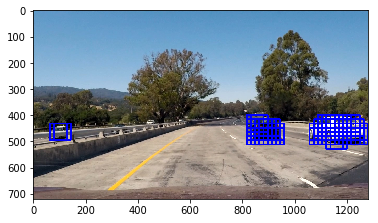

In [7]:
plt.imshow(out_img)

In [8]:
def search_windows(img, windows, clf, scaler):
    img = img.astype(np.float32)/255
    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        #4) Extract features for that window using single_img_features()
        features = single_features(test_img, 32, 32, 9, 8, 2)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

hot_windows = search_windows(img_test, windows, clf_final, X_scaler, )

D:\ProgramFiles\Anaconda\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:248: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


D:\ProgramFiles\Anaconda\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:248: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


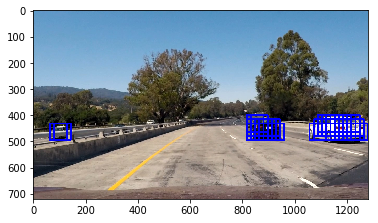

In [9]:

# define a function to divide the picture into several search areas
def search_slice(img, svc, X_scaler):
    bboxes = []
    img_out = np.copy(img)
    for i in range(4):
        scale = i+1
        img_out, bboxes_part = find_cars(img_out, 400, 500, scale, svc, X_scaler)
        bboxes.extend(bboxes_part)
    
    return img_out, bboxes

final_show, final_boxes = search_slice(img_test, clf_final, X_scaler)
plt.imshow(final_show)

D:\ProgramFiles\Anaconda\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:248: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


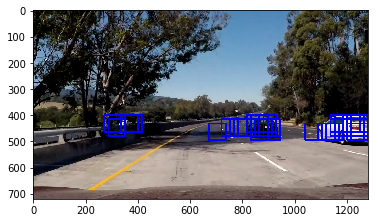

In [10]:
img_test2 = mpimg.imread('./test_images/test5.jpg')
final2, fi_box2 = search_slice(img_test2, clf_final, X_scaler)
plt.imshow(final2)

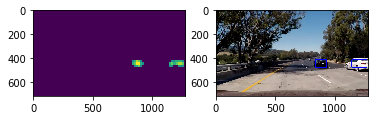

In [11]:
# functions to create heatmap
def add_heat(img, bbox_list, threshold):
    heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
    # Iterate through list of bboxes
    for box in bbox_list:
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
        
    heatmap[heatmap <= threshold] = 0
    heatmap = np.clip(heatmap, 0, 255)
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

heat_test = add_heat(final2, fi_box2, 3)
plt.subplot(1,2,1)
plt.imshow(heat_test)
labels_test = label(heat_test)
draw_img_test = draw_labeled_bboxes(np.copy(img_test2), labels_test)
plt.subplot(1,2,2)
plt.imshow(draw_img_test)

In [12]:
mpimg.imsave("./output_images/draw_img.jpg", draw_img_test)
mpimg.imsave("./output_images/heatmap.jpg",heat_test)

D:\ProgramFiles\Anaconda\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:248: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


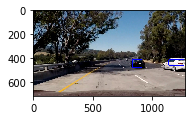

In [13]:
def search_frame(img):
    img_frame = np.copy(img)
    img_result, result_boxes = search_slice(img, clf_final, X_scaler)
    heat_get = add_heat(img_result, result_boxes, 4)
    labels_get = label(heat_get)
    img_out = draw_labeled_bboxes(img_frame, labels_get)
    return img_out

img_final_test = search_frame(img_test2)
plt.subplot(1,2,1)
plt.imshow(img_final_test)
# plt.subplot(1,2,2)
# plt.imshow(heat_out, cmap='gray')

In [14]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = './test_video_output.mp4'
clip1 = VideoFileClip("./test_video.mp4")
white_clip = clip1.fl_image(search_frame) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video ./test_video_output.mp4
[MoviePy] Writing video ./test_video_output.mp4


 97%|███████████████████████████████████████████████████████████████████████████████▉  | 38/39 [01:34<00:02,  2.50s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./test_video_output.mp4 

Wall time: 1min 36s


In [15]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [16]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = './project_video_output.mp4'
clip1 = VideoFileClip("./project_video.mp4")
white_clip = clip1.fl_image(search_frame) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video ./project_video_output.mp4
[MoviePy] Writing video ./project_video_output.mp4


100%|███████████████████████████████████████████████████████████████████████████▉| 1260/1261 [1:33:12<00:04,  4.44s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video_output.mp4 

Wall time: 1h 33min 15s
